<a href="https://colab.research.google.com/github/ZEESHAN14310014/Estimate-Gravity-Using-Ensemble-Kalman-Filter-EnKF-/blob/main/ZeeshanAhmed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparative Study of Gravity Estimation Using EnKF and Capillary Rise Modeling

This notebook performs a comparative study of gravity estimation using Ensemble Kalman Filter (EnKF) and the Lucas–Washburn capillary rise equation. We simulate capillary rise for various known gravity values, generate synthetic noisy observations, and use EnKF to estimate gravity `g`. Finally, we evaluate how accurately the model can recover `g` and assess generalization across different test cases.

## Import Libraries

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

## Define Physical Constants for Capillary Rise in Ethanol

In [ ]:
# Constants for ethanol
sigma = 0.0216      # Surface tension (N/m)
theta = 0           # Contact angle (radians)
mu = 1.174e-3       # Viscosity (Pa.s)
rho = 780           # Density (kg/m^3)
r = 0.000689        # Capillary radius (m)

A = sigma * np.cos(theta) / (2 * mu)

def B(g): return (rho * g * r**2) / (8 * mu)

## Define the ODE and Simulation Function

We implement the second-order Lucas–Washburn capillary rise equation with gravity, inertia, and viscous effects.  
The function `full_capillary_ode` defines the ODE system, and `simulate_ht` numerically integrates it using the `BDF` method for stability over time.

In [ ]:
def full_capillary_ode(t, y, g_val):
  h, v = y  # h = height, v = velocity (dh/dt)
  if h <= 0:
      return [0, 0]  # Prevent non-physical negative heights

  # Capillary force per unit mass
  term1 = (2 * sigma * np.cos(theta)) / (r * rho * h)

  # Viscous drag term
  term2 = (8 * mu * v) / r

  # Inertial term due to kinetic energy change
  term3 = (v**2) / h

  # Net acceleration: dv/dt
  dvdt = term1 - term2 - term3 - g_val

  return [v, dvdt]  # Returns [dh/dt, dv/dt]

def simulate_ht(g_val, h0=1e-5, v0=0.0, t_eval=np.linspace(0.0, 0.5, 20)):
  sol = solve_ivp(
    full_capillary_ode,
    [t_eval[0], t_eval[-1]],  # Time span
    [h0, v0],                 # Initial height and velocity
    t_eval=t_eval,
    args=(g_val,),            # Pass gravity as an argument
    method='BDF',             # Stiff solver
    rtol=1e-10,
    atol=1e-10
  )
  return t_eval, sol.y[0]  # Return time points and height h(t)

### Generate Synthetic Observations for Multiple Gravity Values

In [ ]:
np.random.seed(42) # fix randomness

g_values = [9.81, 3, 5]
synthetic_data = {}

noise_std = 5e-4  # same noise level for all

for g in g_values:
  t_points, h_true = simulate_ht(g)
  h_obs = h_true + np.random.normal(0, noise_std, size=len(h_true))
  synthetic_data[g] = {
    't_points': t_points,
    'h_true': h_true,
    'h_obs': h_obs
  }

### Visualizing Synthetic Observations vs. True Capillary Rise

We generate synthetic noisy observations for multiple values of gravity `g` to simulate experimental conditions. The plot below shows the true capillary height `h(t)` along with the corresponding noisy observations.

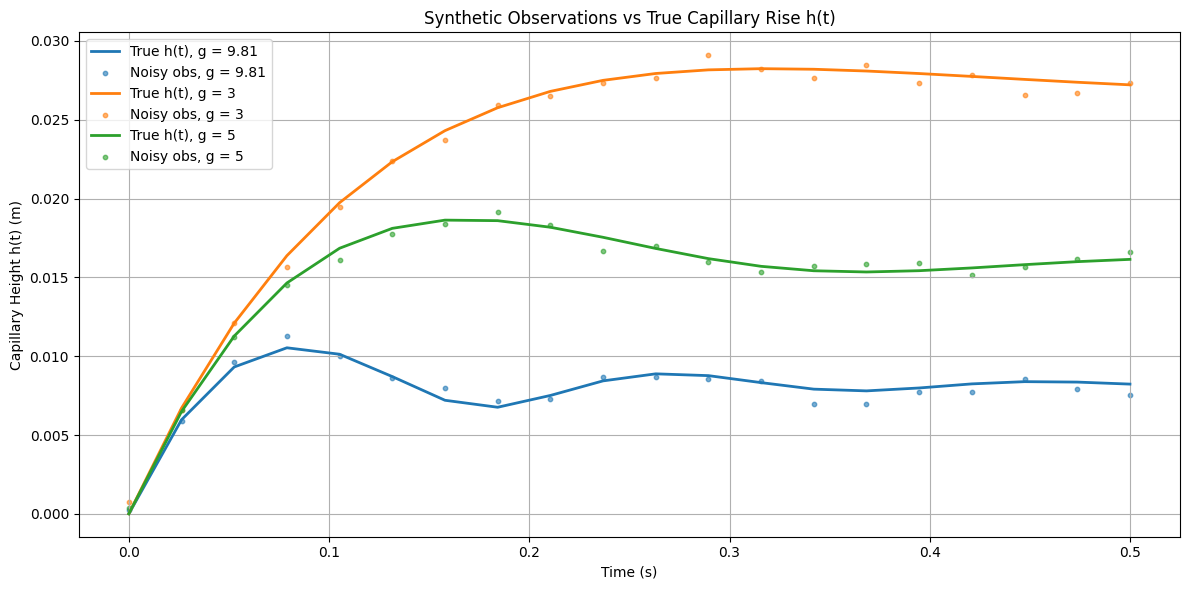

In [ ]:
plt.figure(figsize=(12, 6))

for g in g_values:
  data = synthetic_data[g]
  t = data['t_points']
  h_true = data['h_true']
  h_obs = data['h_obs']

  # True height curve
  plt.plot(t, h_true, label=f"True h(t), g = {g}", linewidth=2)

  # Noisy observation scatter
  plt.scatter(t, h_obs, s=10, alpha=0.6, label=f"Noisy obs, g = {g}")

plt.xlabel("Time (s)")
plt.ylabel("Capillary Height h(t) (m)")
plt.title("Synthetic Observations vs True Capillary Rise h(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Estimate Gravity Using Ensemble Kalman Filter (EnKF)

We now apply the Ensemble Kalman Filter (EnKF) to estimate the gravity value `g` from noisy synthetic observations.

For each gravity value used to generate the data, we run a separate EnKF instance, starting from an initial guess of `g`. The filter iteratively updates the estimate of `g` over time by minimizing the difference between observed and predicted capillary heights `h(t)`. The ensemble approach also allows us to capture uncertainty in the estimates.

In [ ]:
# Run EnKF separately for each gravity level
def enkf_estimate_g(t_points, h_obs, noise_std, initial_mean=8.0):
  # Ensemble size (adjust to 100 for reporting)
  num_ensemble = 5

  # Initialize ensemble of gravity estimates from normal distribution around the initial guess
  g_ensemble = np.random.normal(loc=initial_mean, scale=1.0, size=num_ensemble)
  g_estimates = []  # Store mean gravity estimate at each time step

  # Forward model: simulate h(t) for each g in ensemble
  def forward_model(g_samples):
    return np.array([simulate_ht(g, t_eval=t_points)[1] for g in g_samples])

  # Loop through all time steps
  for i in range(len(t_points)):
    h_pred = forward_model(g_ensemble)  # Predict h(t) for all g samples
    h_model = h_pred[:, i]              # Predicted height at current time step

    h_mean = np.mean(h_model)
    g_mean = np.mean(g_ensemble)

    # Covariance between model output and ensemble g
    cov_hg = np.mean((h_model - h_mean) * (g_ensemble - g_mean))
    var_h = np.var(h_model) + noise_std**2  # Variance + measurement noise

    # Kalman Gain
    K = cov_hg / var_h

    # Perturbed observations (stochastic EnKF)
    perturbed_obs = h_obs[i] + np.random.normal(0, noise_std, num_ensemble)

    # Update g ensemble
    g_ensemble += K * (perturbed_obs - h_model)

    # Store mean estimate at current step
    g_estimates.append(np.mean(g_ensemble))

  return g_estimates

### Run and Visualize EnKF Gravity Estimates

Now that we have implemented the Ensemble Kalman Filter (EnKF), we run it on each set of noisy synthetic data corresponding to different gravity values (`g`). The goal is to track how the EnKF updates its estimate of gravity over time based on the observed capillary height.

The plot below shows the estimated gravity at each time point (in color), compared with the true gravity values (horizontal dashed lines). Convergence of the EnKF estimates toward the true gravity indicates successful learning from noisy observations.

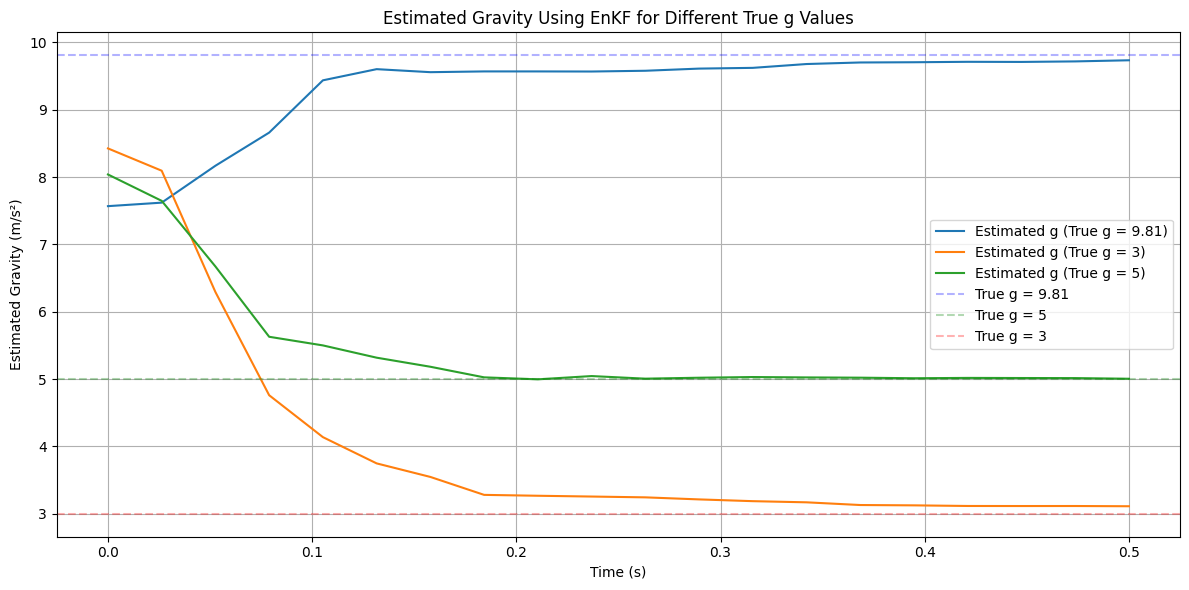

In [ ]:
# These are the g values used to train the model via synthetic observations
plt.figure(figsize=(12, 6))

# Store handles for true gravity lines for legend
true_g_lines = []

for g in g_values:
  # Extract synthetic data for this gravity value
  data = synthetic_data[g]

  # Run EnKF to estimate gravity over time
  g_est = enkf_estimate_g(data['t_points'], data['h_obs'], noise_std)

  # Plot estimated gravity over time
  plt.plot(data['t_points'], g_est, label=f'Estimated g (True g = {g})')

  # Draw horizontal reference line for true gravity value
  color_map = {9.81: 'blue', 5: 'green', 3: 'red'}
  line = plt.axhline(g, linestyle='--', color=color_map[g], alpha=0.3)
  true_g_lines.append(line)

# Add labels and title
plt.xlabel("Time (s)")
plt.ylabel("Estimated Gravity (m/s²)")
plt.title("Estimated Gravity Using EnKF for Different True g Values")

# Add legend for EnKF estimates
plt.legend()

# Add separate legend for true g reference lines
from matplotlib.lines import Line2D
true_g_legend = [
  Line2D([0], [0], color='blue', linestyle='--', alpha=0.3, label='True g = 9.81'),
  Line2D([0], [0], color='green', linestyle='--', alpha=0.3, label='True g = 5'),
  Line2D([0], [0], color='red', linestyle='--', alpha=0.3, label='True g = 3'),
]
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + true_g_legend, loc='best')

# Final layout adjustments
plt.grid(True)
plt.tight_layout()
plt.show()

### Validate EnKF on a Known Gravity Case (g = 9.81)

Before testing EnKF’s ability to generalize to unseen values of gravity, we first validate its performance on a case it was trained on.  
We simulate capillary rise data using `g = 9.81`, add noise, then use EnKF to estimate gravity and simulate the predicted height curve.  
This allows us to visually confirm whether the model faithfully reconstructs the known physical behavior it has seen during training.

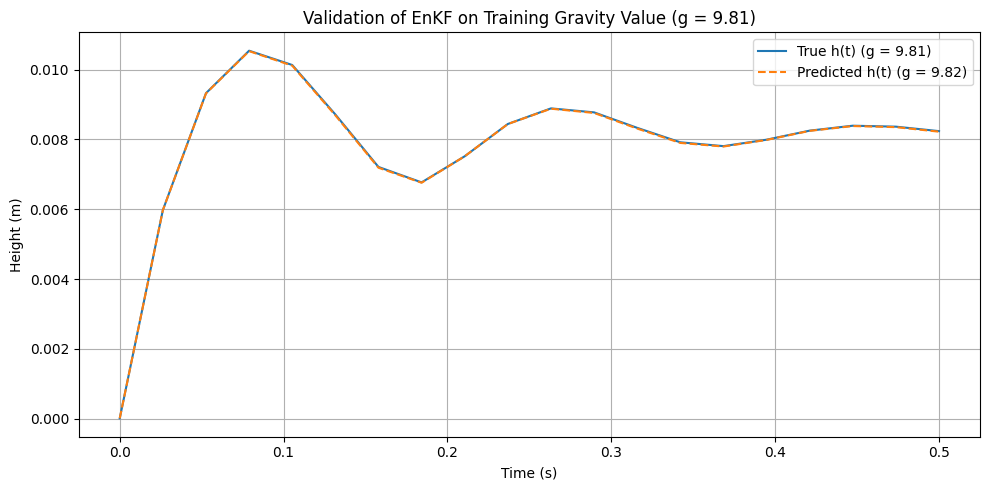

In [ ]:
# Evaluate EnKF prediction on training gravity value (g = 9.81)
g = 9.81
data = synthetic_data[g]  # Use training data

# Estimate gravity using EnKF
g_est = enkf_estimate_g(data['t_points'], data['h_obs'], noise_std)
g_pred = g_est[-1]

# Simulate h(t) using estimated g
_, h_pred = simulate_ht(g_pred)

# Plot true vs predicted height
plt.figure(figsize=(10, 5))
plt.plot(data['t_points'], data['h_true'], label=f"True h(t) (g = {g})")
plt.plot(data['t_points'], h_pred, '--', label=f"Predicted h(t) (g = {g_pred:.2f})")
plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Validation of EnKF on Training Gravity Value (g = 9.81)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Evaluate Generalization of EnKF on Unseen Gravity Values

Now that the EnKF has been trained on synthetic observations for three known gravity values (`9.81`, `5`, and `3`), we test its ability to generalize by evaluating it on intermediate, unseen gravity values. We generate new synthetic data for `g = 2.0`, `4.5`, and `7.2`, and then use the EnKF to estimate gravity from noisy height observations.

This section helps us assess how well the model interpolates and extrapolates beyond its training range.

We also compare the true vs predicted height curves generated using the estimated gravity to visually inspect the accuracy of the inferred physical dynamics.

### Generate synthetic data for intermediate (unseen) `g` values

In [ ]:
# Define intermediate gravity values that were not used during training
test_g_values = [2.0, 4.5, 7.2]

# Dictionary to hold synthetic data for each test gravity value
test_synthetic_data = {}

# Generate synthetic data for each intermediate g value
for g in test_g_values:
  # Simulate true capillary height for given gravity using ODE
  t_points, h_true = simulate_ht(g)

  # Add Gaussian noise to simulate noisy height observations
  h_obs = h_true + np.random.normal(0, noise_std, len(h_true))

  # Store time points, true height, and noisy observations in a dictionary
  test_synthetic_data[g] = {
    't_points': t_points,
    'h_true': h_true,
    'h_obs': h_obs
  }

### Estimate Gravity on Unseen Values Using EnKF

We apply the EnKF to the noisy test data generated above and visualize the estimated gravity over time. We also compare it against the true gravity value using a horizontal reference line.

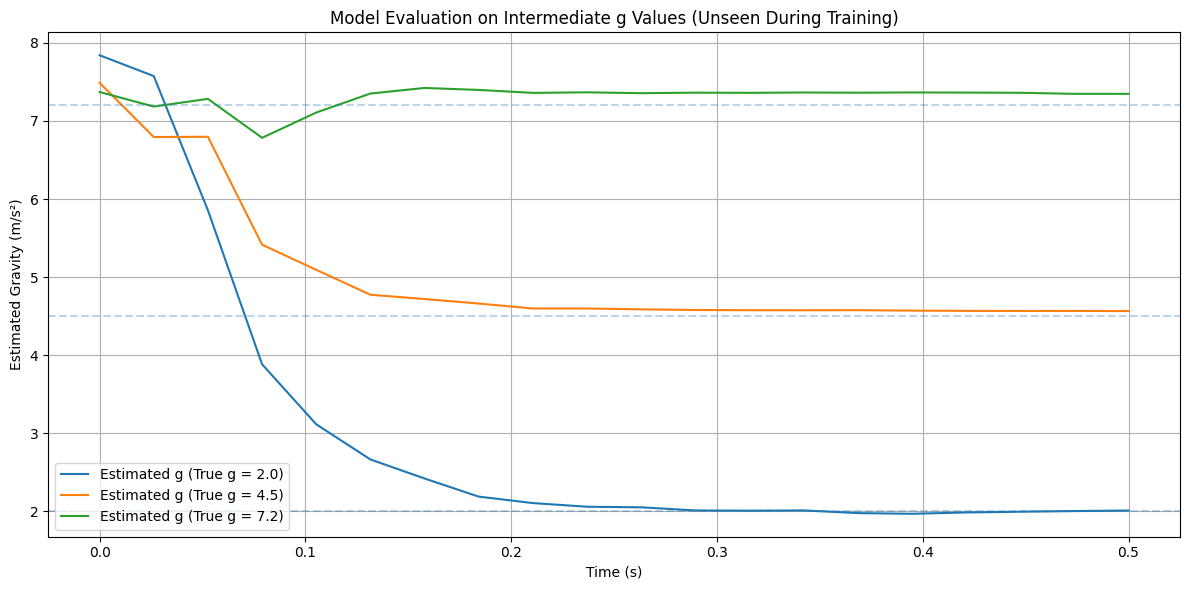

In [ ]:
# Run EnKF on test g values and compare with ODE
plt.figure(figsize=(12, 6))

for g in test_g_values:
  data = test_synthetic_data[g]
  g_est = enkf_estimate_g(data['t_points'], data['h_obs'], noise_std)

  # Plot estimated g over time
  plt.plot(data['t_points'], g_est, label=f'Estimated g (True g = {g})')

  # Add horizontal true g line for visual reference
  plt.axhline(g, linestyle='--', alpha=0.3)

plt.xlabel("Time (s)")
plt.ylabel("Estimated Gravity (m/s²)")
plt.title("Model Evaluation on Intermediate g Values (Unseen During Training)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Compare True vs Predicted h(t) from Estimated `g`

We now compare the true capillary rise curve `h(t)` with the predicted one obtained using the estimated `g` values from EnKF. This visually shows how well the estimated gravity reproduces the underlying physical dynamics.

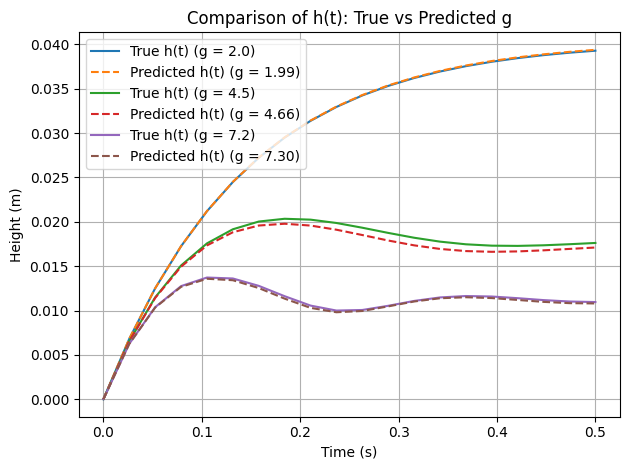

In [ ]:
# Compare true h(t) vs predicted h(t) from estimated `g`
for g in test_g_values:
  data = test_synthetic_data[g]
  g_est = enkf_estimate_g(data['t_points'], data['h_obs'], noise_std)
  g_pred = g_est[-1]

  # Simulate h(t) using the estimated `g`
  _, h_pred = simulate_ht(g_pred)

  # Plot true and predicted h(t)
  plt.plot(data['t_points'], data['h_true'], label=f"True h(t) (g = {g})")
  plt.plot(data['t_points'], h_pred, '--', label=f"Predicted h(t) (g = {g_pred:.2f})")

plt.xlabel("Time (s)")
plt.ylabel("Height (m)")
plt.title("Comparison of h(t): True vs Predicted g")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary of Results and Observations

We evaluated the generalization capability of the Ensemble Kalman Filter (EnKF) by testing it on synthetic data generated using gravity values not seen during training. The EnKF was initially trained on observations corresponding to three known gravity values: 9.81, 5.0, and 3.0. To assess its ability to interpolate and extrapolate, we generated new synthetic datasets for intermediate values of gravity (2.0, 4.5, and 7.2) and applied the EnKF to estimate gravity from noisy height observations.

Our observation:

* The EnKF pedicts reasonable accuracy for intermediate values that were not used during training.
* Estimated gravity values closely matched the true values over time, demonstrating the model's ability to generalize to unseen inputs.
* Simulations of height using the estimated gravity values produced height-time curves that aligned well with the original true height profiles, confirming the reliability of the inferred parameters.


## Possible Extensions and Future Work

* Investigate the effect of different noise levels on the accuracy and stability of EnKF estimates.
* Evaluate the performance of EnKF when trained on more varied gravity ranges with simulation input.
* Compare EnKF with alternative filtering methods such as the Unscented Kalman Filter (UKF) or Particle Filters.
* Extend the framework to more complex multi-phase flow systems.

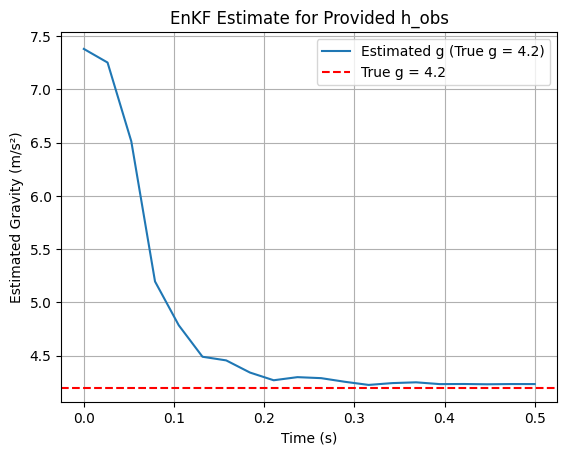

In [ ]:
# Example 1: Use simulated height data with added noise
g_true = 4.2  # any gravity you want to test
t_points, h_true = simulate_ht(g_true)
h_obs = h_true + np.random.normal(0, noise_std, len(h_true))

g_est = enkf_estimate_g(t_points, h_obs, noise_std)

plt.plot(t_points, g_est, label=f"Estimated g (True g = {g_true})")
plt.axhline(g_true, color='r', linestyle='--', label=f"True g = {g_true}")
plt.xlabel("Time (s)")
plt.ylabel("Estimated Gravity (m/s²)")
plt.title("EnKF Estimate for Provided h_obs")
plt.legend()
plt.grid(True)
plt.show()

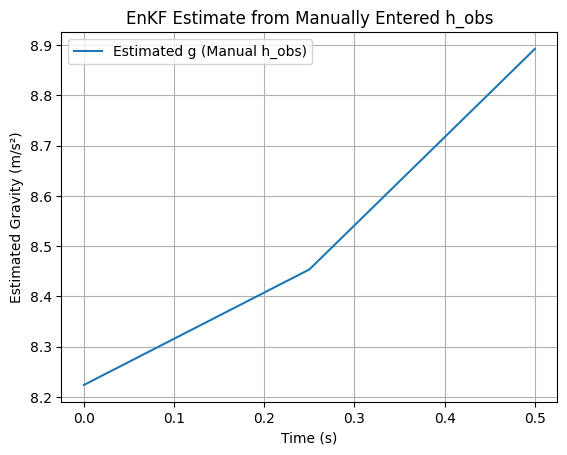

In [ ]:
# Example 2: Manually enter your own observations
t_points = np.linspace(0.0, 0.5, 3)

# Manually enter values or create a pattern (for demo purpose, a parabolic decay)
# Replace this with your real-world h_obs values as needed
#h_obs_manual = 1e-5 - 0.5 * 4.5 * t_points**2
h_obs_manual = (0.008, 0.008, 0.008) ###

g_est_manual = enkf_estimate_g(t_points, h_obs_manual, noise_std)

plt.plot(t_points, g_est_manual, label="Estimated g (Manual h_obs)")
plt.xlabel("Time (s)")
plt.ylabel("Estimated Gravity (m/s²)")
plt.title("EnKF Estimate from Manually Entered h_obs")
plt.legend()
plt.grid(True)
plt.show()

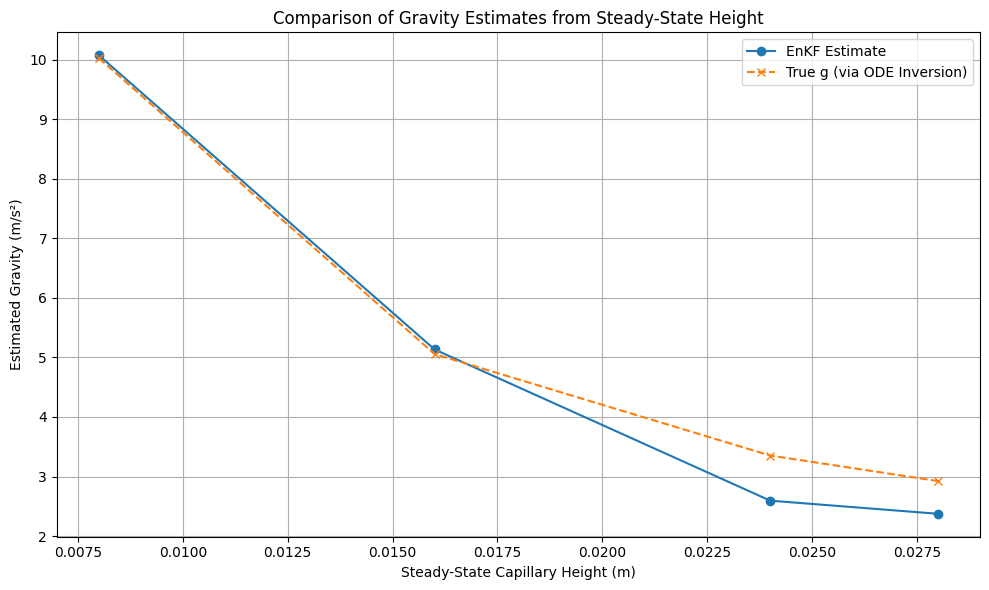

In [ ]:
# Estimate gravity using EnKF from a steady observed capillary height.
def estimate_g_from_steady_height(h_obs_value, t_start=0.0, t_end=0.5, num_points=20):
  # Create repeated time points
  t_points = np.linspace(t_start, t_end, num_points)

  # Create repeated steady height observations
  h_obs_manual = np.full_like(t_points, h_obs_value)

  # Run EnKF
  g_est_manual = enkf_estimate_g(t_points, h_obs_manual, noise_std)

  # Return final gravity estimate (last time point)
  return g_est_manual[-1]

# Estimate gravity g_val from observed steady-state height using inverse ODE simulation.
def estimate_g_from_height(h_obs, t_eval=np.linspace(0.0, 0.5, 20)):
  def objective(g_val):
      _, h_sim = simulate_ht(g_val, t_eval=t_eval)
      h_steady = h_sim[-1]  # Last value = steady-state height
      return abs(h_steady - h_obs)  # Loss function

  # Use bounded scalar minimization to find best-fit g
  result = minimize_scalar(objective, bounds=(1.0, 15.0), method='bounded')

  if result.success:
      return result.x  # Estimated gravity value
  else:
      raise RuntimeError("Gravity estimation failed")

def estimate_gravity_from_heights(h_values):
  g_estimates_enkf = []
  g_estimates_true = []

  for h in h_values:
      # EnKF estimation
      g_enkf = estimate_g_from_steady_height(h)
      g_estimates_enkf.append(g_enkf)

      # ODE-based true g estimation
      g_true = estimate_g_from_height(h)
      g_estimates_true.append(g_true)

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.plot(h_values, g_estimates_enkf, marker='o', label='EnKF Estimate')
  plt.plot(h_values, g_estimates_true, marker='x', linestyle='--', label='True g (via ODE Inversion)')

  plt.xlabel("Steady-State Capillary Height (m)")
  plt.ylabel("Estimated Gravity (m/s²)")
  plt.title("Comparison of Gravity Estimates from Steady-State Height")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

  return g_estimates_enkf, g_estimates_true

heights_to_test = [0.008, 0.016, 0.024, 0.028]
g_enkf, g_true = estimate_gravity_from_heights(heights_to_test)